In [2]:
import SimPEG as simpeg
import simpegMT as simpegmt
import numpy as np, os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
## Setup the modelling
# Setting up 1D mesh and conductivity models to forward model data.

# Frequency
nFreq = 31
freqs = np.logspace(3,-3,nFreq)
# Set mesh parameters
ct = 10
air = simpeg.Utils.meshTensor([(ct,25,1.3)])
core = np.concatenate( (  np.kron(simpeg.Utils.meshTensor([(ct,5,-1.2)]),np.ones((3,))) , simpeg.Utils.meshTensor([(ct,5)]) ) )
bot = simpeg.Utils.meshTensor([(core[0],25,-1.3)])
x0 = -np.array([np.sum(np.concatenate((core,bot)))])
# Make the model
m1d = simpeg.Mesh.TensorMesh([np.concatenate((bot,core,air))], x0=x0)

# Setup model varibles
active = m1d.vectorCCx<0.
layer1 = (m1d.vectorCCx<-200.) & (m1d.vectorCCx>=-600.)
layer2 = (m1d.vectorCCx<-2000.) & (m1d.vectorCCx>=-4000.)
# Set the conductivity values
sig_half = 2e-3
sig_air = 1e-8
sig_layer1 = 1
sig_layer2 = .1
# Make the true model
sigma_true = np.ones(m1d.nCx)*sig_air
sigma_true[active] = sig_half
sigma_true[layer1] = sig_layer1
sigma_true[layer2] = sig_layer2
# Extract the model 
m_true = np.log(sigma_true[active])
# Make the background model
sigma_0 = np.ones(m1d.nCx)*sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])

# Set the mapping
actMap = simpeg.Maps.ActiveCells(m1d, active, np.log(1e-8), nC=m1d.nCx)
mappingExpAct = simpeg.Maps.ExpMap(m1d) * actMap

In [4]:
## Setup the layout of the survey, set the sources and the connected receivers

# Receivers 
rxList = []
for rxType in ['z1dr','z1di']:
    rxList.append(simpegmt.SurveyMT.RxMT(simpeg.mkvc(np.array([0.0]),2).T,rxType))
# Source list
srcList =[]
for freq in freqs:
        srcList.append(simpegmt.SurveyMT.srcMT_polxy_1Dprimary(rxList,freq))
# Make the survey
survey = simpegmt.SurveyMT.SurveyMT(srcList)
survey.mtrue = m_true
# Set the problem
problem = simpegmt.ProblemMT1D.eForm_psField(m1d,sigmaPrimary=sigma_0,mapping=mappingExpAct)
from pymatsolver import MumpsSolver
problem.solver = MumpsSolver
problem.pair(survey)

In [5]:
## Forward model observed data 
# Project the data
std = 0.05 # 5% std
if os.path.isfile('MT1D_dtrue.npy') and os.path.isfile('MT1D_dobs.npy'):
    d_true = np.load('MT1D_dtrue.npy')
    d_obs = np.load('MT1D_dobs.npy')
else:
    d_true = survey.dpred(m_true)
    np.save('MT1D_dtrue.npy',d_true)
    d_obs = std*abs(d_true)*np.random.randn(*d_true.shape)
    np.save('MT1D_dobs.npy',d_obs)
# Assign the dobs
survey.dtrue = d_true
survey.dobs = d_obs
survey.std = survey.dobs*0 + std
# Assign the data weight
survey.Wd = 1/(abs(survey.dobs)*survey.std)

In [6]:
## Setup the inversion proceedure

# Define a counter
C =  simpeg.Utils.Counter()
# Set the optimization
opt = simpeg.Optimization.InexactGaussNewton(maxIter = 50)
opt.counter = C
opt.LSshorten = 0.5
opt.remember('xc')
# Data misfit
dmis = simpeg.DataMisfit.l2_DataMisfit(survey)
# Regularization
# Either have to use 
if True:
    regMesh = simpeg.Mesh.TensorMesh([m1d.hx[problem.mapping.sigmaMap.maps[-1].indActive]],m1d.x0)
    reg = simpeg.Regularization.Tikhonov(regMesh)
else:
    reg = simpeg.Regularization.Tikhonov(m1d,mapping=mappingExpAct)
reg.alpha_s = 1e-6
reg.alpha_x = 1.

# Inversion problem
invProb = simpeg.InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.counter = C
# Beta cooling
beta = simpeg.Directives.BetaSchedule()
betaest = simpeg.Directives.BetaEstimate_ByEig(beta0_ratio=0.75)
targmis = simpeg.Directives.TargetMisfit()
saveModel = simpeg.Directives.SaveModelEveryIteration()
saveModel.fileName = 'Inversion_TargMisEqnDregMesh'
# Create an inversion object
inv = simpeg.Inversion.BaseInversion(invProb, directiveList=[beta,betaest,targmis,saveModel]) 


In [7]:
# Run the inversion, given the background model as a start.
mopt = inv.run(m_0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.l2_DataMisfit is creating default weightings for Wd.
SimPEG.SaveModelEveryIteration will save your models as: '###-Inversion_TargMisEqnDregMesh.npy'
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  5.15e+05  1.32e+06  2.95e+00  2.83e+06    3.23e+05      0              
   1  5.15e+05  1.66e+05  2.77e+00  1.59e+06    3.93e+04      0              
   2  5.15e+05  2.22e+04  2.75e+00  1.44e+06    7.05e+03      0   Skip BFGS  
------------------------------------------------------------------
0 :    ft     = 1.4405e+06 <= alp*descent     = 1.4405e+06
1 : maxIterLS =      10    <= iterLS          =     10
------

/home/gudni/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2834: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a record
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  if (obj.__array_interface__["data"][0]
/home/gudni/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2835: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a record
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  != self.__array_interface__["data"][0]):


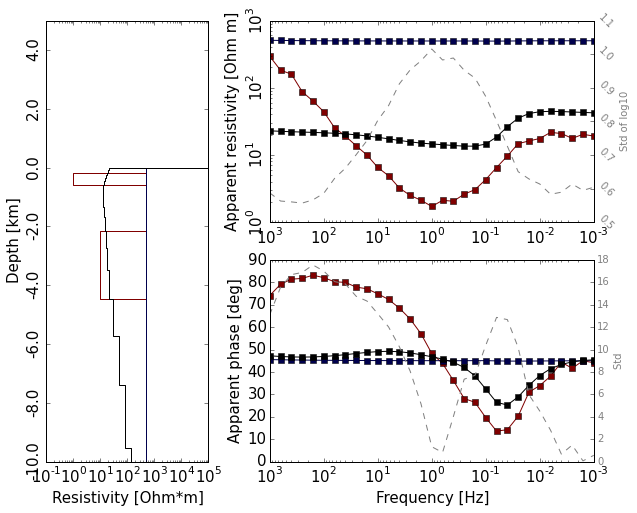

In [8]:
%matplotlib inline
simpegmt.Utils.dataUtils.plotMT1DModelData(problem,[m_0,mopt])
plt.show()
